# Email Spam or Ham Classifier
Dataset: https://www.kaggle.com/datasets/bilaliqbalai/spam-ham-dataset

Github: https://github.com/sherpa-lakpa/spam-detection

Live: https://spam-detection-ihty.onrender.com/

## Import Necessary Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# importing Stopwords
import nltk
from nltk.corpus import stopwords
import string

# models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# train test split
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# score
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score



## Load and Explore the Dataset

In [15]:
df=pd.read_csv('spam_dataset.csv')

In [17]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [18]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [19]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [16]:
df["text"][0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

## Data Cleaning
Handle missing values

In [37]:
# Drop rows with missing values in the 'label' column
df = df.dropna(subset=['label'])

In [39]:
df = df.dropna(subset=['text'])

In [40]:
# Confirm that the dataset is clean
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
 4   length      5171 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 202.1+ KB


## Exploratory data analysis


1.Text Length Calculation:

 A new column named 'length' was added to the dataset, representing the character length of each text.

2.Overview of the Dataset:

 The first few rows of the dataset, now including the 'length' column, were displayed to provide an initial glimpse of the data.

3.Count of Spam and Ham Messages:

 A count plot was created to visualize the distribution of 'spam' and 'ham' (non-spam) labels in the dataset. This plot helps to understand the balance or imbalance between spam and non-spam messages.

4.Distribution of Text Length:

 A histogram was generated to display the distribution of text lengths. This provides insights into the range of character lengths present in the dataset.

5.Maximum Text Length:

 The text with the maximum length was identified and presented. This information helps to understand the extreme values in the dataset.

6.Distribution of Spam and Ham by Text Length:

 Separate histograms were created for 'spam' and 'ham' labels to illustrate the distribution of text lengths within each category. This analysis helps in understanding if there are differences in text length between spam and non-spam messages.

The entire process contributes to a better understanding of the dataset characteristics, facilitating further analysis and potential feature engineering for machine learning models.

In [21]:
# adding new column as length of the text
df['length'] = df['text'].apply(len)
df.head()

,Unnamed: 0,label,text,label_num,length
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,414
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,336


Text(0.5, 1.0, 'Number of Spam and Ham')

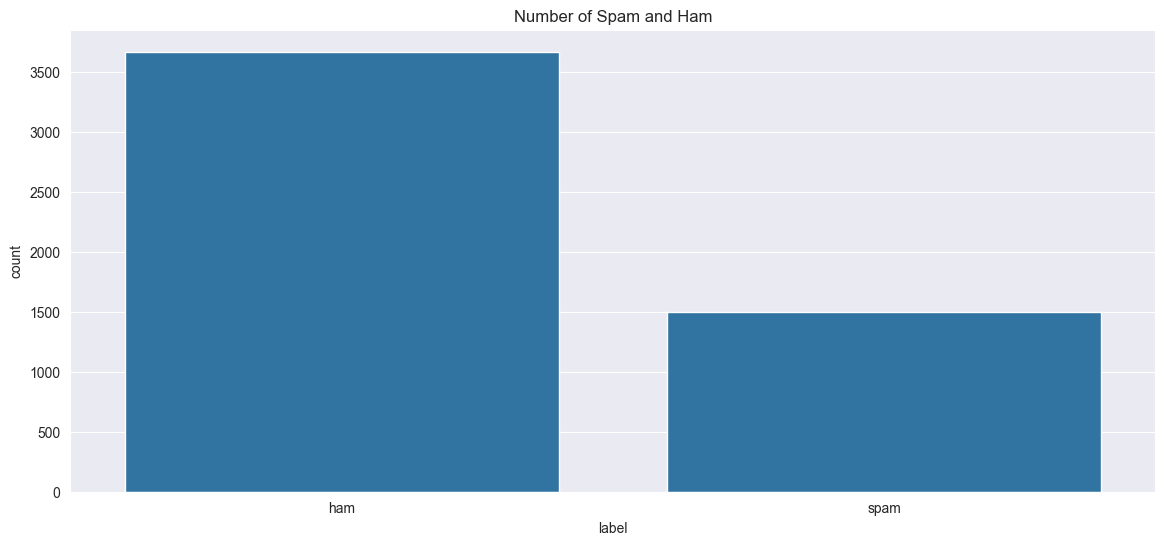

In [22]:
# plot for count of spam and ham in data
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(x='label',data=df)
plt.title('Number of Spam and Ham')

Text(0.5, 1.0, 'Length of Text')

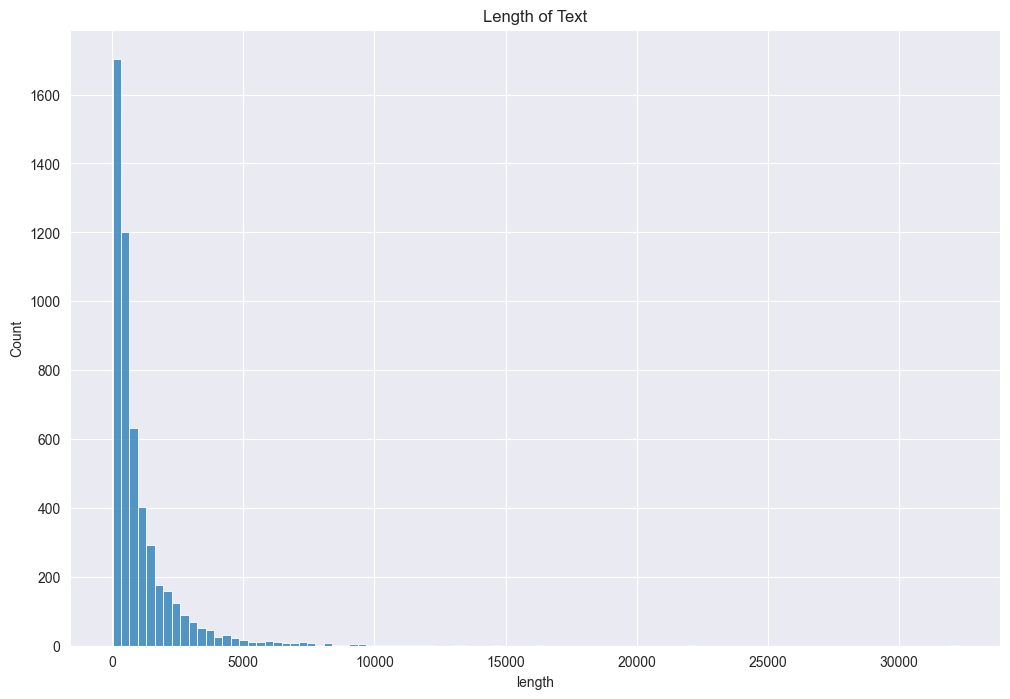

In [23]:
# Plot for distribution lenth of text
plt.figure(figsize=(12,8))
sns.histplot(x='length',data=df,bins=100)
plt.title('Length of Text')

In [24]:
# maximum lenth text 
df[df['length']==df['length'].max()]['text']

949    Subject: fw : " red , white and blue out "\r\n...
Name: text, dtype: object

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

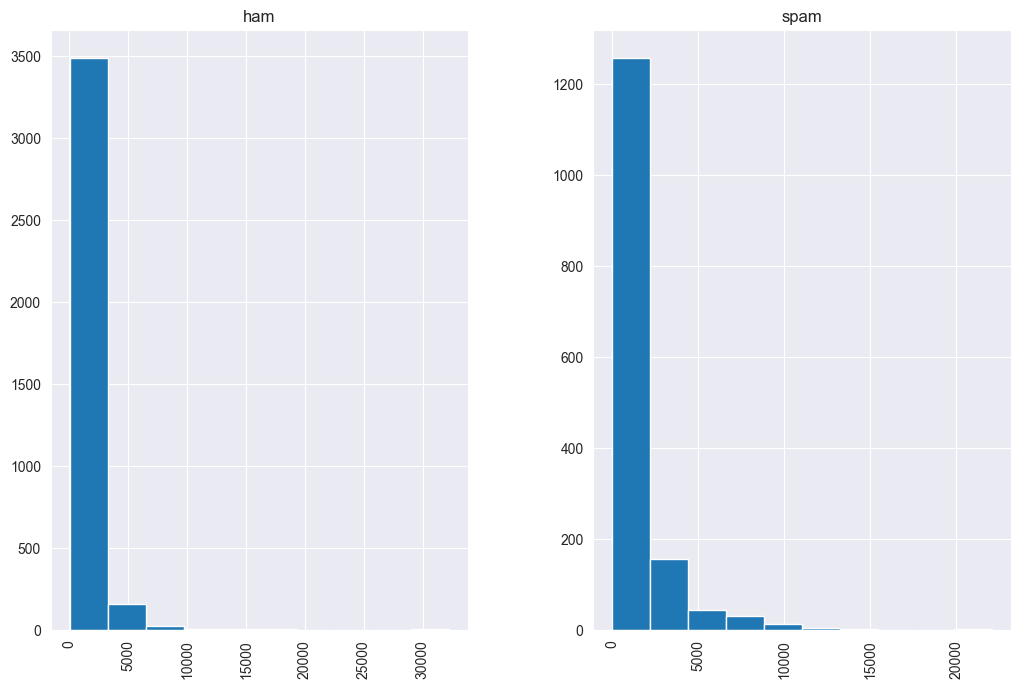

In [25]:
# distribution of spam and ham by length of text
df.hist(column='length',by='label',figsize=(12,8))

## Feature Enginering

1.Function Definition:

The function is defined with the name text_process and takes a single argument, text, which represents the input text that needs to be processed.

2.Punctuation Removal:

The function uses a list comprehension to iterate through each character in the input text (text). Characters that are not in the set of string punctuation are retained.
The list of characters without punctuation is then joined into a single string, effectively removing punctuation from the text.

3.Stopword Removal:

The resulting string without punctuation is then split into words.
Another list comprehension is used to create a list of words that are not in the set of English stopwords. Stopwords are common words like "the," "and," "is," etc., which are often removed in natural language processing tasks as they do not contribute significant meaning.

4.Final Result:

The function returns the list of words obtained after removing punctuation and stopwords.
Purpose:

The purpose of this text processing function is to clean and prepare textual data for further analysis or modeling. By removing punctuation, the function helps in simplifying the text, and by eliminating stopwords, it focuses on the more meaningful words that carry more significant information.

In [26]:
# function to remove punctuation and stopwords
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

## Train Test Split

1.Train-Test Split:

The train_test_split function from the scikit-learn library is used to split the dataset into training and testing sets.
The features (X) and the target variable (y) are split into training and testing sets with a test size of 33% (specified by test_size=0.33).
The random_state parameter is set to 42, ensuring reproducibility by fixing the random seed.

2.Resulting Variables:

X_train: The training set of features.
X_test: The testing set of features.
y_train: The training set of target variable values.
y_test: The testing set of target variable values.

Purpose:

The purpose of this code is to prepare the dataset for machine learning by separating the features (input) and the target variable (output). The dataset is then split into training and testing sets to assess the model's performance on unseen data.

In [41]:
# Split the data into features and target
X= df['text']
y=df['label']

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Model Selection
Creating a pipline to model the data

Pipeline in Machine Learning:

A pipeline in machine learning is a way to streamline a lot of the routine processes, making it easier to organize, replicate, and share your workflow. It strings together a sequence of data processing steps, where each step is represented by a tuple containing a name and an instance of an estimator or a transformer. The pipeline is particularly useful when there is a need to automate a sequence of different data processing steps, such as data cleaning, feature extraction, and model training.

How Pipeline Works:

1.Initialization:

A pipeline is initialized with a list of tuples, where each tuple represents a step in the process.
Each step consists of a name (a string) and an instance of an estimator or a transformer.

2.Fit Method:

When the fit method is called on the pipeline, it sequentially applies each step's fit method to the input data.
For transformers, it fits the transformation to the data. For the final estimator, it fits the model to the transformed data.

3.Transform Method (Optional):

If there are transformers in the pipeline, the transform method is applied to the data.
This step is optional and may not be needed for all pipelines.

4.Predict Method (Optional):

If the final step is an estimator (a model), the predict method is applied to make predictions on new data.
Explanation of Provided Code:

The below cide defines three pipelines, each consisting of three main steps:

Text Processing (Feature Extraction):
The 'bow' step uses CountVectorizer with the custom text_process function. It converts a collection of text documents to a matrix of token counts.

Term Frequency-Inverse Document Frequency (TF-IDF) Transformation:
The 'tf' step uses TfidfTransformer to transform the count matrix from 'bow' into a normalized term-frequency or term-frequency times inverse document-frequency (TF-IDF) representation.

Classifier:
The 'classifier' step uses different classifiers for each pipeline: MultinomialNB for pipe_mnb, RandomForestClassifier for pipe_rf, and SVC (Support Vector Classifier) for pipe_svc.


Multinomial Naive Bayes (pipe_mnb):

It uses CountVectorizer for feature extraction, followed by TF-IDF transformation, and a Multinomial Naive Bayes classifier.
Random Forest (pipe_rf):

It uses the same text processing and TF-IDF steps but employs a Random Forest classifier.

Support Vector Classifier (pipe_svc):

Similar to the others, it uses text processing and TF-IDF transformation, but the classifier is a Support Vector Classifier.

Fitting the Pipelines:

After defining each pipeline, the fit method is called on each pipeline to train the respective models using the training data (X_train and y_train). Each pipeline follows the defined sequence of text proces

### pipeline for MultinomialNB

In [59]:
pipe_mnb = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

pipe_mnb.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x14fbcb6d0>)),
                ('tf', TfidfTransformer()), ('classifier', MultinomialNB())])

### pipeline for Random Forest Classifier

In [60]:
pipe_rf =Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x14fbcb6d0>)),
                ('tf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

### pipeline for Random Forest Classifier

In [61]:
pipe_svc =Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',SVC())
])

pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x14fbcb6d0>)),
                ('tf', TfidfTransformer()), ('classifier', SVC())])

In [47]:
### predict the target feature
pred_mnb = pipe_mnb.predict(X_test)
pred_rf = pipe_rf.predict(X_test)
pred_svc = pipe_svc.predict(X_test)

# Prediction Accuracy

In [48]:
print('The accuracy for Multinomial Classifer:',accuracy_score(y_test,pred_mnb)*100)
print('The accuracy for Random_forest Classifer:',accuracy_score(y_test,pred_rf)*100)
print('The accuracy for SVC:',accuracy_score(y_test,pred_svc)*100)

The accuracy for Multinomial Classifer: 91.73989455184535
The accuracy for Random_forest Classifer: 97.65670767428236
The accuracy for SVC: 98.82835383714118


The accuracy for the Multinomial Naive Bayes classifier is approximately 91.74%.

The accuracy for the Random Forest classifier is approximately 97.66%.

The accuracy for the Support Vector Classifier is approximately 98.83%.

The accuracy scores indicate the proportion of correctly classified instances in the test dataset.
Higher accuracy values generally suggest better performance, but it's important to consider the specific requirements of the problem and potentially use additional metrics for a more comprehensive evaluation.

**The SVC predicts better tham Random Forest Model and Multinomial.**

## Hyperparameter Tuning
Use GridSearchCV to find the best hyperparameters

Hyperparameter Tuning:

Hyperparameter tuning is the process of finding the best set of hyperparameters for a machine learning model. Hyperparameters are external configuration settings that cannot be learned from the data and need to be set before training the model. Tuning these hyperparameters is crucial to optimize a model's performance.

In the  code, a Support Vector Classifier (SVC) is used, and hyperparameter tuning is performed using  Grid Search. Grid Search involves defining a grid of hyperparameter values and evaluating the model's performance for each combination of these values.

Explanation of the Code:

TF-IDF Vectorization:

TfidfVectorizer is used to convert the raw text data into a TF-IDF representation. This step is essential for transforming text data into a numerical format that can be fed into the machine learning model.
fit_transform is used on the training data (X_train) to fit the vectorizer and transform the training data. transform is then used on the test data (X_test) to transform it using the same vectorizer.

Grid Search for Hyperparameter Tuning:

A dictionary (param_grid) is defined with different values for hyperparameters ('C', 'gamma', 'kernel') that the grid search will explore.
A Support Vector Classifier (SVC) is instantiated.
GridSearchCV is used to perform a grid search over the specified hyperparameter values. The 'accuracy' metric is used for scoring, and cross-validation with 5 folds (cv=5) is employed.
The grid search is fitted to the TF-IDF transformed training data (X_train_tfidf, y_train).

The best hyperparameters found by the grid search are {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}.

2.'C': 10:

'C' is the regularization parameter in a Support Vector Machine (SVM) or Support Vector Classifier (SVC).
It controls the trade-off between having a smooth decision boundary and classifying the training points correctly.
A higher 'C' value means a more strict classification of the training points, potentially leading to a more complex decision boundary.

2.'gamma': 0.1:

'gamma' is a parameter that defines how far the influence of a single training example reaches.
A low 'gamma' value indicates a large influence, meaning the points far from the decision boundary have a strong effect on the decision boundary.
A higher 'gamma' value makes the decision boundary more dependent on the points close to it.

3.'kernel': 'rbf':

'kernel' specifies the kernel type used in the algorithm. 'rbf' stands for Radial Basis Function.
The radial basis function kernel is commonly used in SVMs. It allows the algorithm to learn complex decision boundaries.

The output provides the hyperparameters that resulted in the highest accuracy during the grid search process.
These hyperparameters can be used to instantiate a new SVC model with the optimized configuration.

In [52]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [53]:
pipe_svc.named_steps['classifier'].get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Model Evaluation

In [54]:
# Make prclasses_edictions on the test set
y_pred = grid_search.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9882835383714118


In [58]:
# print confusion matrix and classification report
print ('Classification report on SVC:')
print('\n')
print(classification_report(y_test,y_pred))

Classification report on SVC:


              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      1246
        spam       0.97      0.99      0.98       461

    accuracy                           0.99      1707
   macro avg       0.98      0.99      0.99      1707
weighted avg       0.99      0.99      0.99      1707



Text(0.5, 1.0, 'Confusion Matrix for SVC')

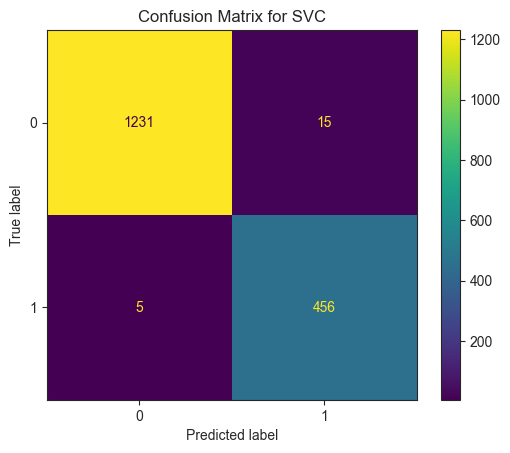

In [57]:
# Display confusioni matrix for SVC

sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix for SVC")

## Pickle File

In [ ]:
import joblib

joblib.dump(pipe_svc, 'pipe_spam_model.pkl')

## Task Distribution

| Task                       | Pradeep                  | Lakpa                    |
|----------------------------|--------------------------|--------------------------|
| *Data Cleaning*          | Data Cleaning            |                          |
|                            |                          |                          |
| *EDA and Visualization*  | EDA and Visualization    |                          |
|                            |                          |                          |
| *Feature Engineering*    | Feature Engineering      |                          |
|                            |                          |                          |
| *Model Evaluation*       | Model Evaluation         |                          |
|                            |                          |                          |
| *Model Selection*        |                          | Model Selection          |
|                            |                          |                          |
| *Pipeline Building*      |                          | Pipeline Building        |
|                            |                          |                          |
| *Hyperparameter Tuning*  |                          | Hyperparameter Tuning    |
|                            |                          |                          |
| *Flask Web App Development*|                          | Flask Web App Development|
|                            |                          |                          |
| *Deployment*             | Deployment               | Deployment               |